# Detecting Cancer in the CAMELYON16 dataset

## Download and Preprocessing multi-scale data

This notebook is the second half part of data preprocessing. The first part is in the notebook *1.0 Preprocessing (single-scale).ipynb*. In this part, I read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset using [OpenSlide](https://openslide.org/). By extracting patches from the original gigapixel microscopy images (`100,000*100,000` pixels) under zoom level 3, 4 and 5, I create relatively smaller dataset that can be directly used in the model.

The original slides and annotations is in the [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) containing all the slides and tumor masks that have already converted. Note that I only use a subset of the CAMELYON16 dataset.

The processed data is shared publicly at [Google Cloud](https://storage.googleapis.com/slides_xh2465/data_from2.zip) which is free for you to download. This notebook converts the original slides into patches of size `299*299` at zoom level 3, 4, 5. 

Multi-scale approach is inspired by pathologists work flow of examining a slide at multiple magnifications to get context. I used zoom level 4 and 5 to get extra context information for the patches we want to predict at level 3. The data is grouped by its labels (normal/tumor) which is determined by the center `128*128 `region at level 3. If there is at least one pixel in the center region masked as cancerous, then the label is 1 and otherwise 0. To extract patche images, a sliding window is used with stride 128 (which matches the size of center patch).


In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openslide import open_slide, __library_version__ as openslide_version
import os
import random
import pathlib, shutil
from PIL import Image
from skimage.color import rgb2gray
from google.colab import drive
import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = 'storied-smile-311319'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://augmented_patches/
gs://hw4_xh2465/
gs://slices-xh2465/
gs://slides_xh2465/


In [ ]:
# Mount drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

The following list records number of all the slides in the data [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 21 tumor slide samples in the data.

In [ ]:
numbers = ['001', '002', '005', '012', '016', '019', '023', '031', '035', '057', '059', 
          '064', '075', '078', '081', '084', '091', '094', '096', '101', '110']
train_slides = numbers[:13]
val_slides = numbers[13:17]
test_slides = numbers[17:]

## Data Preprocessing

Note that the process is similar to what I have done in the previous single-scale notebook. Slide a window of stride 128 across the whole slide and output `299*299` patches as well as label on the center `128*128` patch. However, now we are using multiscale approach. There should be 3 patches for every center patch. Visiting data on multiscale is a little bit complicated. So I stored patches according to their scale. There is also a dataframe telling us the path of the patch image we want. Each row represents a patch on the slide image. The dataframe have four columns, including paths of its context patch at level 3, 4, 5 and its corresponding label. 

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# This is the function to look at all the gray regions
# To increase efficiency, ignore non-tissue areas of the slide
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))
 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [ ]:
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [ ]:
class Prepare_data():

    def __init__(self, name, slide_path, tumor_mask_path):
        self.name = name
        # directory to store the patch data
        self.patch_dir = pathlib.Path('/content/data/'+str(name))

        # read the slide
        self.slide = open_slide(slide_path)
        print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                        self.slide.level_dimensions[0][0], 
                                        self.slide.level_dimensions[0][1]))
        # read the tumor mask
        self.tumor_mask = open_slide(tumor_mask_path)
        print ("Read tumor mask from %s" % (tumor_mask_path))
        print("Slide includes %d levels" % len(self.slide.level_dimensions))

        # Code to examine each level and check the dimension of slide and tumor mask matches.
        self.levels = []
        for i in range(min(len(self.slide.level_dimensions), len(self.tumor_mask.level_dimensions))):
            if self.tumor_mask.level_dimensions[i][0] == self.slide.level_dimensions[i][0] and self.tumor_mask.level_dimensions[i][1] == self.slide.level_dimensions[i][1]:
                self.levels.append(i)
                print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                        self.slide.level_dimensions[i], 
                                        self.slide.level_downsamples[i]))
            
            else:
                break

    def extract_patches(self, base_level, magnigications=2, stride=128, patch_size=299, center_size=128):
        print('extracting data from level ', str(base_level))
        # get size of the slide at current level
        width, height = self.slide.level_dimensions[base_level]
        data_column = ['image_level' + str(i) for i in range(base_level, base_level+1+magnigications)] + ['label']
        self.df = pd.DataFrame(columns=data_column)
        # i, j is the x, y coordinates on the image. 
        # Specifically, they are coordinates of the top left corner of the slide window at level 3
        # k is the index of slide window
        i, j, k = 0, 0, 0
        patches, labels = [], []
        # Create new folder for the patches
        for level in range(base_level, 1+base_level+magnigications):
            if os.path.exists(pathlib.Path(str(self.patch_dir) + '/' + str(level))): # Clear the existing test directory
                shutil.rmtree(pathlib.Path(str(self.patch_dir) + '/' + str(level)), ignore_errors=False)
            os.makedirs(pathlib.Path(str(self.patch_dir) + '/' + str(level)))

        # Stop iteration when the window reaches the edge of the image.
        while j <= height - patch_size:
            while i <= width - patch_size:
                # Get the center patch of the current patch
                center_image = read_slide(self.slide, 
                                        x=(i+85) * (2**base_level), 
                                        y=(j+85) * (2**base_level), 
                                        level=base_level, 
                                        width=center_size, 
                                        height=center_size)
                # Discard patches with no tissue pixel
                if len(find_tissue_pixels(center_image)) == 0:
                    i += stride
                    continue
                # Create a new row on the dataframe
                self.df.loc[k, :] = None
                # Get the mask
                mask_image = read_slide(self.tumor_mask, 
                                        x=(i+85) * (2**base_level), 
                                        y=(j+85) * (2**base_level), 
                                        level=base_level, 
                                        width=center_size, 
                                        height=center_size)[:,:,0]
                # Get the label. If there is any tumor in this patch, the label is 1 otherwise 0.
                label = mask_image.max()
                self.df.loc[k, 'label'] = label

                # get context patch at different level
                for level in range(base_level, base_level+1+magnigications):
                    # The offset of the top left coordinate for each level
                    offset = (2**(level-base_level)-1) * patch_size // 2
                    patch_image = read_slide(self.slide, 
                                        x=(i-offset) * (2**base_level), 
                                        y=(j-offset) * (2**base_level), 
                                        level=level, 
                                        width=patch_size, 
                                        height=patch_size)
                    # Save patches to different folders according to its level
                    data_dir = pathlib.Path(str(self.patch_dir) + '/' + str(level) + '/' + str(i-offset)+'_'+str(j-offset) + '.jpg')
                    im = Image.fromarray(patch_image)
                    im.save(data_dir)
                    # Save the path to the dataframe
                    self.df.loc[k, 'image_level' + str(level)] = str(data_dir)


                i += stride
                k += 1
            i = 0
            j += stride

### Extract and save patches

Similar as previous work for single-scale. But now I create a dataframe for each slide to record the path of patches at different zoom level.

In [ ]:
data_files = ['tumor_' + num for num in numbers]
data_dir = 'https://storage.googleapis.com/slices-xh2465/'
dfs = []
# iterate over all slides
for filename in data_files:
    # download data
    slide_url = data_dir + filename + '.tif'
    mask_url = data_dir + filename + '_mask.tif'
    !curl -O $slide_url
    !curl -O $mask_url
    # Extract patches
    slide_path = filename + '.tif'
    tumor_mask_path = filename + '_mask.tif'
    preparation = Prepare_data(filename, slide_path, tumor_mask_path)
    preparation.extract_patches(3)
    dfs.append(preparation.df)
    # Remove the original data file to save memory
    !rm {slide_path}
    !rm {tumor_mask_path}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3113M  100 3113M    0     0  78.2M      0  0:00:39  0:00:39 --:--:-- 92.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 93.8M  100 93.8M    0     0  86.1M      0  0:00:01  0:00:01 --:--:-- 86.1M
Read WSI from tumor_001.tif with width: 97792, height: 221184
Read tumor mask from tumor_001_mask.tif
Slide includes 10 levels
Level 0, dimensions: (97792, 221184) downsample factor 1
Level 1, dimensions: (48896, 110592) downsample factor 2
Level 2, dimensions: (24448, 55296) downsample factor 4
Level 3, dimensions: (12224, 27648) downsample factor 8
Level 4, dimensions: (6112, 13824) downsample factor 16
Level 5, dimensions: (3056, 6912) downsample factor 32
Level 6, dimensions: (1528, 3456) downsample factor 64
Level 7

### Sanity Check

Because extracting patches from different zoom level is complicated and a little bit abstract, I use following codes to display some image in our data to make sure that everything works as expected.

In [ ]:
# display a few data points in the dataframe
# each data point has three patches images at level 3, 4, 5 which share the same center
# and the label of the center patch
def random_display(df, n):
    for i in range(n):
        idx = random.choice(df.index)
        for column in df.columns[:-1]:
            print(column)
            path = df.loc[idx, column]
            img = tf.io.read_file(path)  # read
            img = tf.image.decode_jpeg(img, channels=3)  # decode
            plt.imshow(img) # plot the image
            plt.show()
        print('label: ', df.loc[idx, 'label'])
        print()

Here is one example.

image_level3


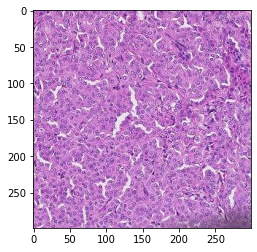

image_level4


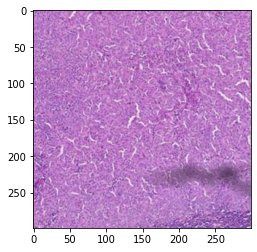

image_level5


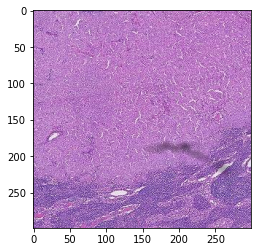

label:  1



In [ ]:
random_display(dfs[20], 1)

## Save and upload data

Now, compress the data and upload them to Google Cloud.

### Save images

In [ ]:
shutil.make_archive('augmented_data', 'zip', pathlib.Path('/content/data/'))

'/content/augmented_data.zip'

In [ ]:
bucket_name = 'augmented_patches'
!gsutil -m cp -r /content/augmented_data.zip gs://{bucket_name}/multiscale_level3to5

Copying file:///content/augmented_data.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/4.8 GiB.                                      


### Save dataframes

In [ ]:
colab_root = "/content/"

Separate train, validation and test data. The first 13 slides is assigned to the train set, and next 4 to validation and last 4 to test set. In that case, we make sure that there is no information leak between train, validation and test.

In [ ]:
train_df = pd.concat(dfs[:13])
val_df = pd.concat(dfs[13:17])
test_df = pd.concat(dfs[17:])

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(71209, 4)
(19606, 4)
(23606, 4)


In [ ]:
train_df.head()

,image_level3,image_level4,image_level5,label
0,/content/data/tumor_001/3/0_0.jpg,/content/data/tumor_001/4/-149_-149.jpg,/content/data/tumor_001/5/-448_-448.jpg,0
1,/content/data/tumor_001/3/128_0.jpg,/content/data/tumor_001/4/-21_-149.jpg,/content/data/tumor_001/5/-320_-448.jpg,0
2,/content/data/tumor_001/3/256_0.jpg,/content/data/tumor_001/4/107_-149.jpg,/content/data/tumor_001/5/-192_-448.jpg,0
3,/content/data/tumor_001/3/384_0.jpg,/content/data/tumor_001/4/235_-149.jpg,/content/data/tumor_001/5/-64_-448.jpg,0
4,/content/data/tumor_001/3/512_0.jpg,/content/data/tumor_001/4/363_-149.jpg,/content/data/tumor_001/5/64_-448.jpg,0


In [ ]:
train_df.to_csv(colab_root+'train_df.csv')
bucket_name = 'augmented_patches'
!gsutil -m cp -r /content/train_df.csv gs://{bucket_name}/multiscale_level3to5

Copying file:///content/train_df.csv [Content-Type=text/csv]...
/ [1/1 files][  8.7 MiB/  8.7 MiB] 100% Done                                    
Operation completed over 1 objects/8.7 MiB.                                      


In [ ]:
val_df.to_csv(colab_root+'val_df.csv')
bucket_name = 'augmented_patches'
!gsutil -m cp -r /content/val_df.csv gs://{bucket_name}/multiscale_level3to5

Copying file:///content/val_df.csv [Content-Type=text/csv]...
/ [1/1 files][  2.4 MiB/  2.4 MiB] 100% Done                                    
Operation completed over 1 objects/2.4 MiB.                                      


In [ ]:
test_df.to_csv(colab_root+'test_df.csv')
bucket_name = 'augmented_patches'
!gsutil -m cp -r /content/test_df.csv gs://{bucket_name}/multiscale_level3to5

Copying file:///content/test_df.csv [Content-Type=text/csv]...
/ [1/1 files][  2.9 MiB/  2.9 MiB] 100% Done                                    
Operation completed over 1 objects/2.9 MiB.                                      
